# Image Classification using AWS SageMaker

 In this project, you will be using AWS Sagemaker to finetune a pretrained model that can perform image classification. You will have to use Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices to finish this project. The choice of dataset is up to you. For instance, you can use the dog breed classication(opens in a new tab) dataset to classify between different breeds of dogs in images.

## Instructions

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug seaborn bokeh -q

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import glob
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import IPython
import torch
import torchvision
import torchvision.transforms as transforms
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
Rule,
rule_configs,
DebuggerHookConfig,
ProfilerRule,
ProfilerConfig, 
FrameworkProfile
)
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from mpl_toolkits.axes_grid1 import host_subplot

from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2024-07-28 10:15:04.498 default:201 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

Now, let's extract data from s3 and count number of image.

In [3]:
# Command to download and unzip data
# Please uncomment if you download data 
# !wget --no-check-certificat https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip -q dogImages.zip 

In [4]:
# Get current working directory
current_dir = os.getcwd()

# Define a search pattern to find all JPG files within four subdirectories
search_pattern = os.path.join(current_dir, "*/" * 3, "*.jpg")

# Find all JPG files matching the pattern
file_pth_lst = glob.glob(search_pattern)

# Filter files based on presence of "train", "valid", or "test" in the path
train_pth_lst = [pth for pth in file_pth_lst if "train" in pth]
valid_pth_lst = [pth for pth in file_pth_lst if "valid" in pth]
test_pth_lst = [pth for pth in file_pth_lst if "test" in pth]

In [5]:
print(f"""
    number of image in train:{len(train_pth_lst)} \n
    number of image in valid:{len(valid_pth_lst)} \n
    number of image in test:{len(test_pth_lst)}""")


    number of image in train:13359 

    number of image in valid:1670 

    number of image in test:1672


### Extracting label and class from data path
This structure makes it easy to identify which class each image belongs to within the dataset.

* example1: /dogImages/dataset type/label.class/class_number.jpg 
* exapmple2: /dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg

### Explanation of each part

* /dogImages/: The top-level directory name. (root directory).
* dataset type: Indicates the type of dataset. (e.g., train, valid, test).
* label.class: Represents the label and class of the image. label means the label name, and class means the class name. 
* class_number.jpg: The class number and the file name of the image. class_number is a unique number for the image within that class (e.g., 1.jpg, 2.jpg).


### Overview of dataset

In [6]:
def get_pth2metadata(pth_list):
    df =pd.DataFrame([pth.split('/')[-2].split('.') for pth in pth_list])
    df.columns = ['label','class']
    df['label'] = df['label'].astype(int)
    df = df[['class', 'label']]
    
    df['filenames'] = [pth.split('/')[-1] for pth in pth_list]
    
    agg_df = pd.DataFrame(df['class'].value_counts()).reset_index()
    agg_df = agg_df.sort_values(by='class')
    return df, agg_df

train_df, train_agg_df = get_pth2metadata(train_pth_lst)
valid_df, valid_agg_df = get_pth2metadata(valid_pth_lst)
test_df, test_agg_df = get_pth2metadata(test_pth_lst)

print(f"Number of dog type:{len(train_df['class'].unique())}")

Number of dog type:134


The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

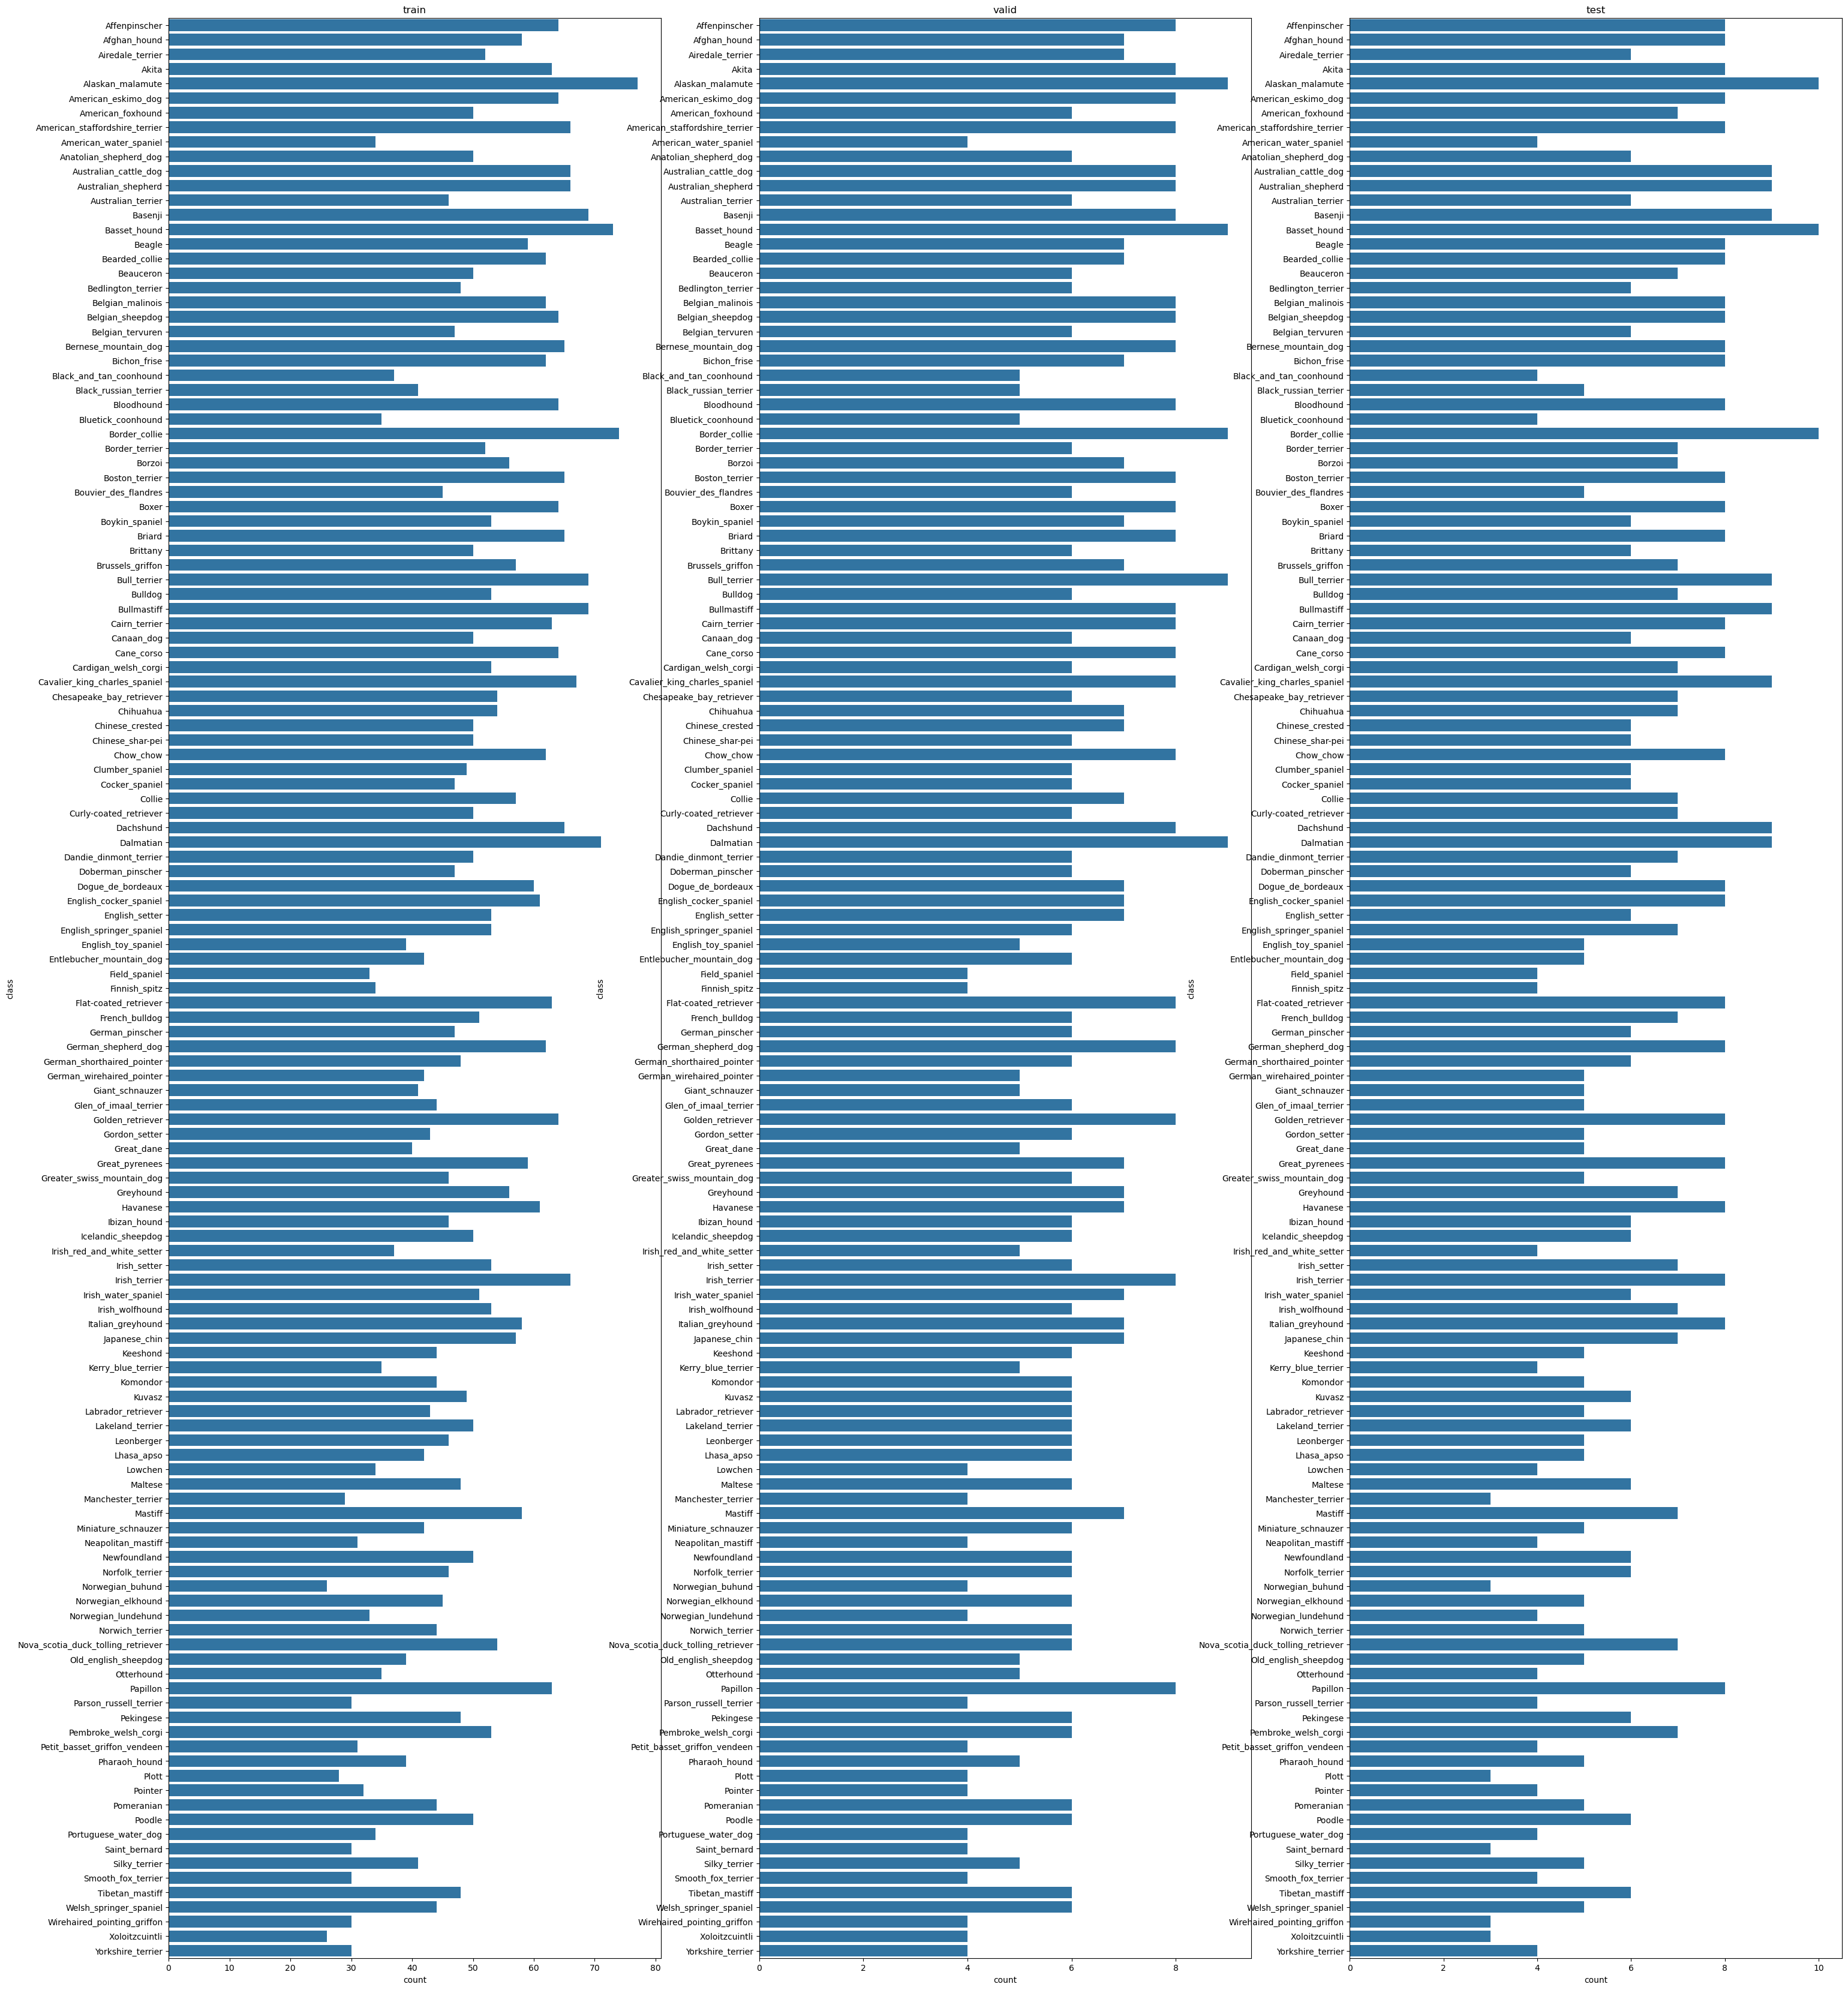

In [7]:
plt.figure(figsize=[36, 42])
plt.subplot(1,3,1)
sns.barplot(data=train_agg_df, x='count', y='class');
plt.title('train');

plt.subplot(1,3,2)
sns.barplot(data=valid_agg_df, x='count', y='class');
plt.title('valid');

plt.subplot(1,3,3)
sns.barplot(data=test_agg_df, x='count', y='class');
plt.title('test');

The train data and the valid/test data show a similar trend in the number of data per label, although the number of images differs.

### check image data

(480, 360)


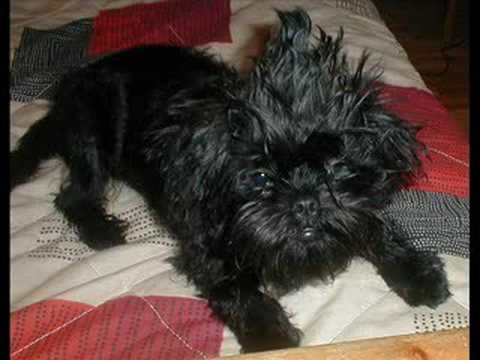

None
(321, 316)


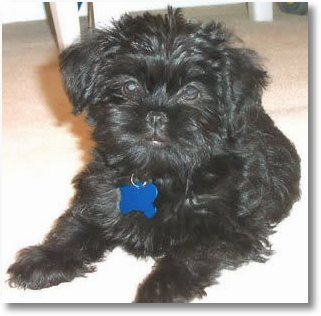

None
(500, 375)


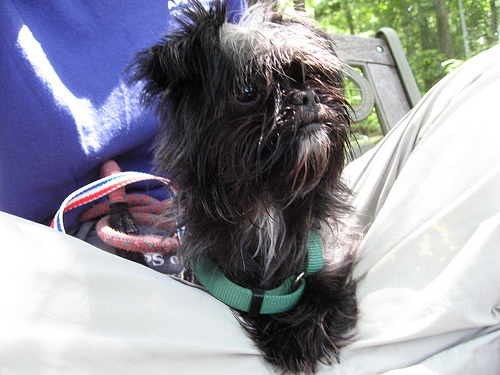

None
(360, 270)


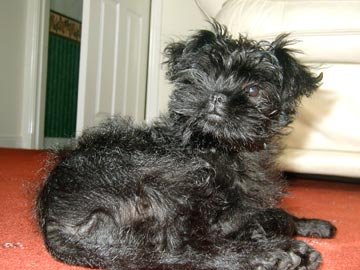

None


In [8]:
for idx in range(1,5):
    image = Image.open(train_pth_lst[idx])
    print(f"{image.size}")
    print(image.show())

In [9]:
!rm -r ./dogImages_cleaned
!rsync -av --include '*/' ./dogImages/* ./dogImages_cleaned -q


In [10]:
target_pth = [x for x in glob.glob(current_dir+'/*/*/*') if 'dogImages_cleaned' in x]

for pth in target_pth:
    os.rename(pth, pth.split('.')[0])

In [11]:
image_pth = [x for x in glob.glob(current_dir+'/*/*/*/*') if 'dogImages_cleaned' in x]

error_lst = []
for pth in image_pth:
    try:
        image = Image.open(pth)
        image.resize((256, 256))
    except:
        error_lst.append(pth)
        print(f'An exception occurred in {pth}')

An exception occurred in /home/sagemaker-user/nd009t-c3-deep-learning-topics-within-computer-vision-nlp-project-starter/dogImages_cleaned/train/098/Leonberger_06571.jpg


In [12]:
for file_path in error_lst:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_path} is deleted")
    else:
        print(f"{file_path} does not exists")

/home/sagemaker-user/nd009t-c3-deep-learning-topics-within-computer-vision-nlp-project-starter/dogImages_cleaned/train/098/Leonberger_06571.jpg is deleted


### Load data to S3

In [9]:
sagemaker_session = sagemaker.Session(default_bucket='sagemaker-studio-146700155215-5c7uj0emdok')
bucket = sagemaker_session.default_bucket()

print('Default Bucket: {}'.format(bucket))

region = sagemaker_session.boto_region_name
print('AWS Region: {}'.format(region))

role = get_execution_role()
print('RoleArn: {}'.format(role))

Default Bucket: sagemaker-studio-146700155215-5c7uj0emdok
AWS Region: us-west-2
RoleArn: arn:aws:iam::146700155215:role/service-role/AmazonSageMaker-ExecutionRole-20240708T070637


## Load data to s3

In [26]:
path = f'./dogImages_cleaned/'
key_prefix = f'nd009t-c2/dataset'

train_s3_uri = sagemaker_session.upload_data(path=path, 
                                             bucket=bucket, 
                                             key_prefix=key_prefix)

In [10]:
os.environ['SM_CHANNEL_TRAINING'] = f's3://{bucket}/nd009t-c2/dataset'
os.environ['SM_MODEL_DIR'] = f's3://{bucket}/nd009t-c2/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = f's3://{bucket}/nd009t-c2/hpo/'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [15]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.01, 0.1),
    'momentum': ContinuousParameter(0.01, 0.9),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Test Loss: testing_loss: ([0-9\\.*.]+)"}]

In [16]:
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='pytorch',
    output_path = f's3://{bucket}/nd009t-c2/hpo/',
    role=role,
    py_version='py3',
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.p3.2xlarge'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [ ]:
# TODO: Fit your HP Tuner
# TODO: Remember to include your data channels

tuner.fit(os.environ['SM_CHANNEL_TRAINING'] , wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-07-24 13:37:35 Starting - Starting the training job
2024-07-24 13:37:35 Pending - Found matching resource for reuse
2024-07-24 13:37:35 Downloading - Downloading the training image
2024-07-24 13:37:35 Training - Training image download completed. Training in progress.
2024-07-24 13:37:35 Uploading - Uploading generated training model
2024-07-24 13:37:35 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Test Loss"',
 'lr': '0.08021660533908867',
 'momentum': '0.8892639160580738',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-2024-07-24-11-46-53-455"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-west-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-studio-146700155215-5c7uj0emdok/pytorch-2024-07-24-11-46-53-455/source/sourcedir.tar.gz"'}

In [15]:
hyperparameters = {'lr':best_estimator.hyperparameters()['lr'],
  'momentum':best_estimator.hyperparameters()['momentum']
 }
hyperparameters

{'lr': '0.08021660533908867', 'momentum': '0.8892639160580738'}

In [19]:
hyperparameters = {'lr': '0.08021660533908867', 'momentum': '0.8892639160580738'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [20]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "1000", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [21]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point='train_model.py',
    base_job_name='pytorch',
    output_path = f's3://{bucket}/nd009t-c2/train_model/',
    role=role,
    py_version='py3',
    hyperparameters=hyperparameters,
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

estimator.fit(os.environ['SM_CHANNEL_TRAINING'], wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-2024-07-28-10-34-09-670


2024-07-28 10:34:10 Starting - Starting the training job...
2024-07-28 10:34:21 Pending - Training job waiting for capacityVanishingGradient: InProgress
Overfit: InProgress
ProfilerReport: InProgress
...
2024-07-28 10:35:08 Pending - Preparing the instances for training...
2024-07-28 10:35:28 Downloading - Downloading input data...
2024-07-28 10:36:09 Downloading - Downloading the training image...........................
2024-07-28 10:40:29 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-28 10:40:32,971 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-28 10:40:33,000 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-07-28 10:40:33,003 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-07-28 10:40:33,268 sagemaker-training-too

In [16]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [18]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2024-07-28 01:49:05.410 default:127 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-studio-146700155215-5c7uj0emdok/nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/debug-output
[2024-07-28 01:49:06.400 default:127 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-07-28 01:49:07.419 default:127 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'CrossEntropyLoss_output_1',
 'CrossEntropyLoss_output_2',
 'CrossEntropyLoss_output_3',
 'CrossEntropyLoss_output_4',
 'CrossEntropyLoss_output_5',
 'CrossEntropyLoss_output_6',
 'CrossEntropyLoss_output_7',
 'CrossEntropyLoss_output_8',
 'CrossEntropyLoss_output_9',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


<Figure size 400x3600 with 0 Axes>

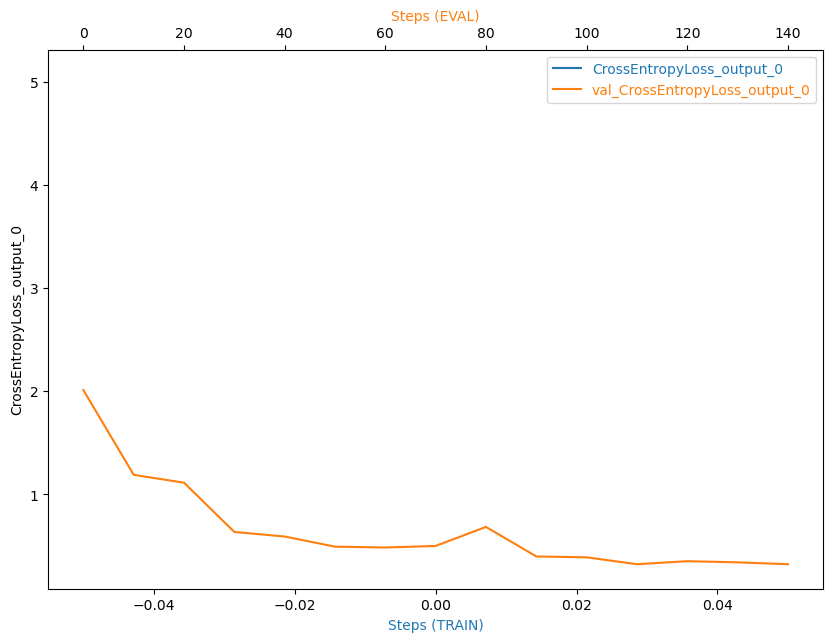

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


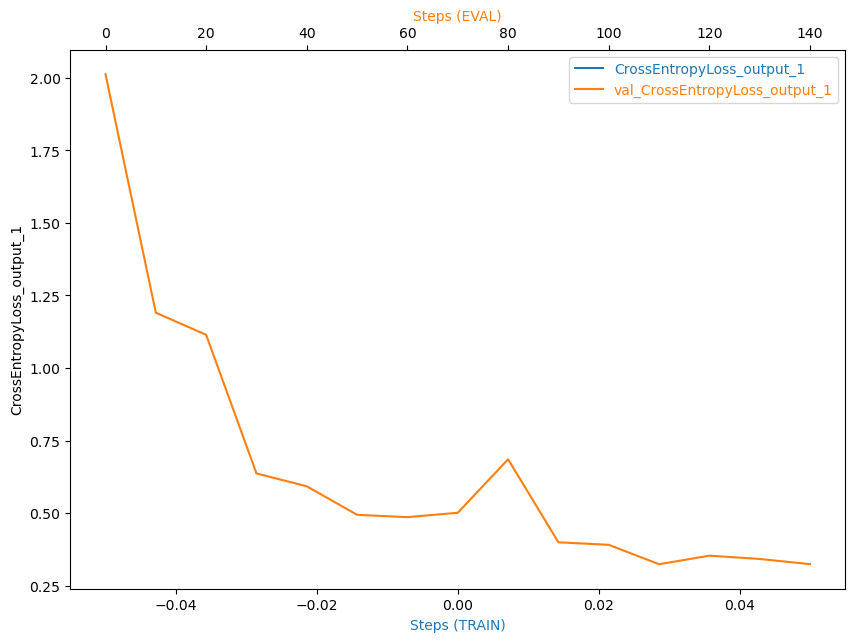

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


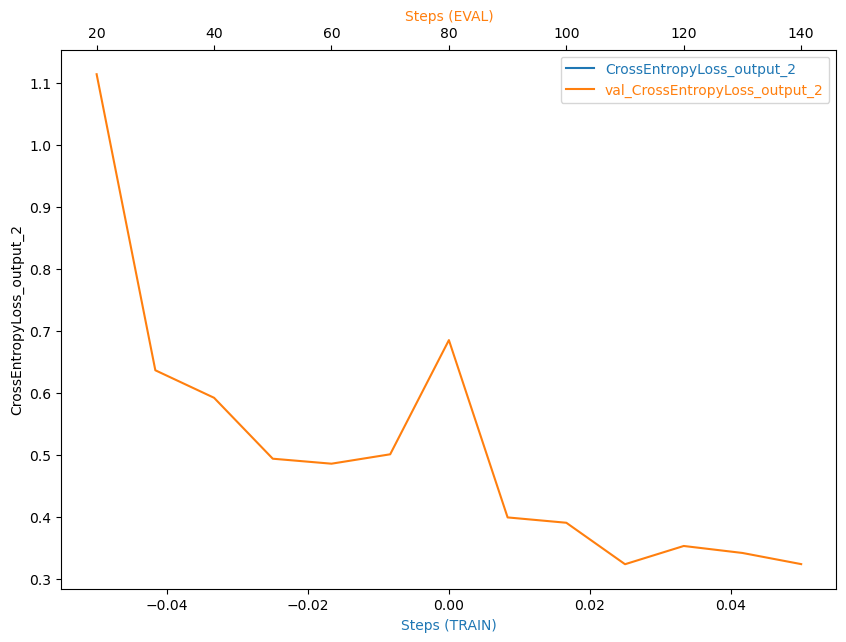

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


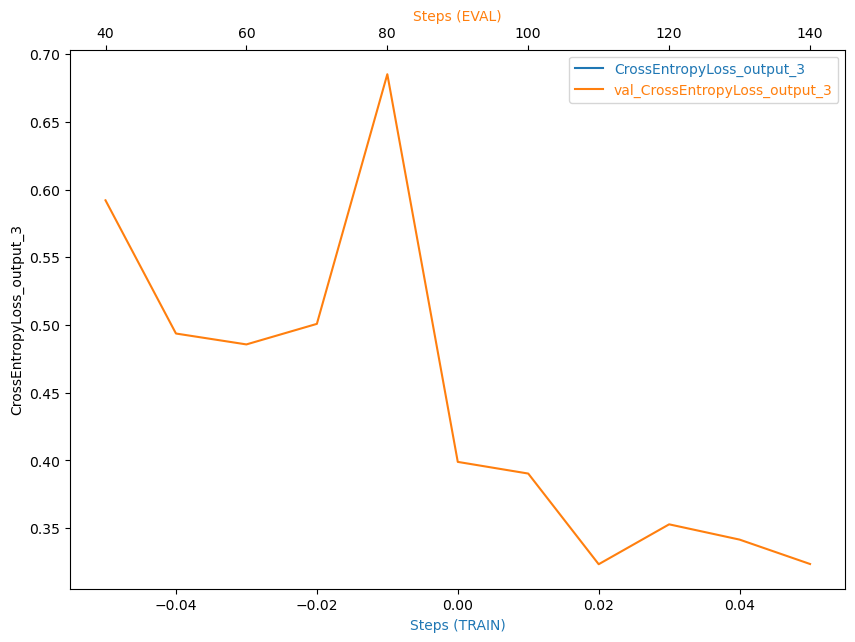

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


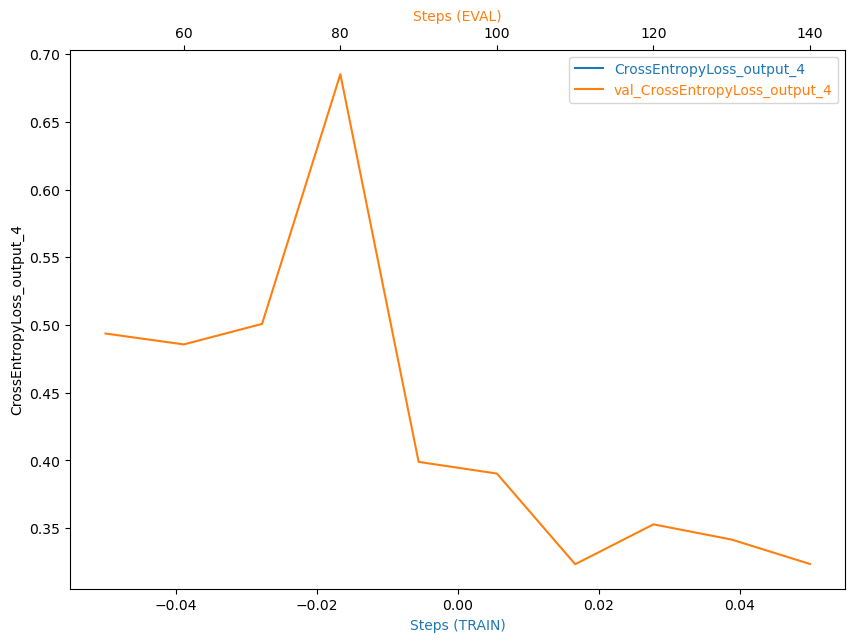

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


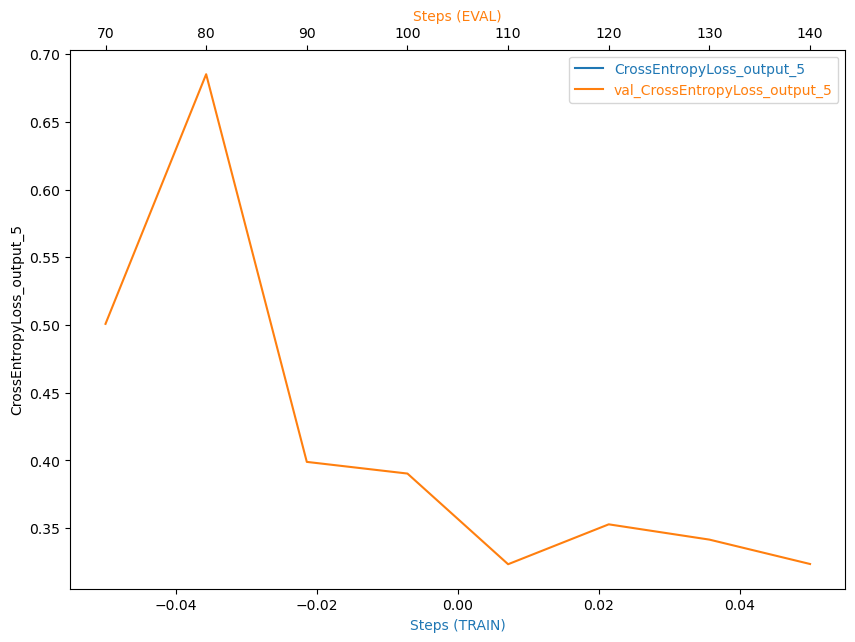

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


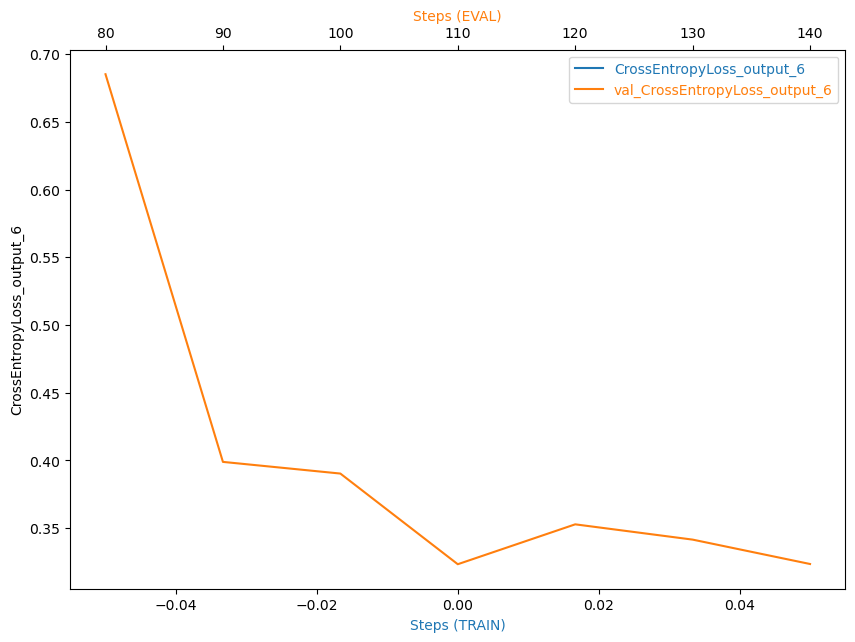

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


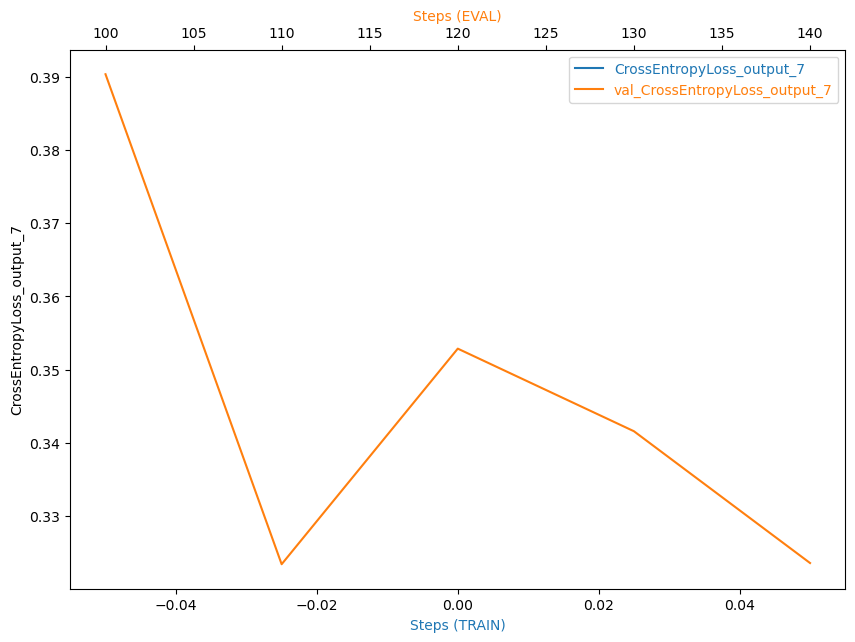

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


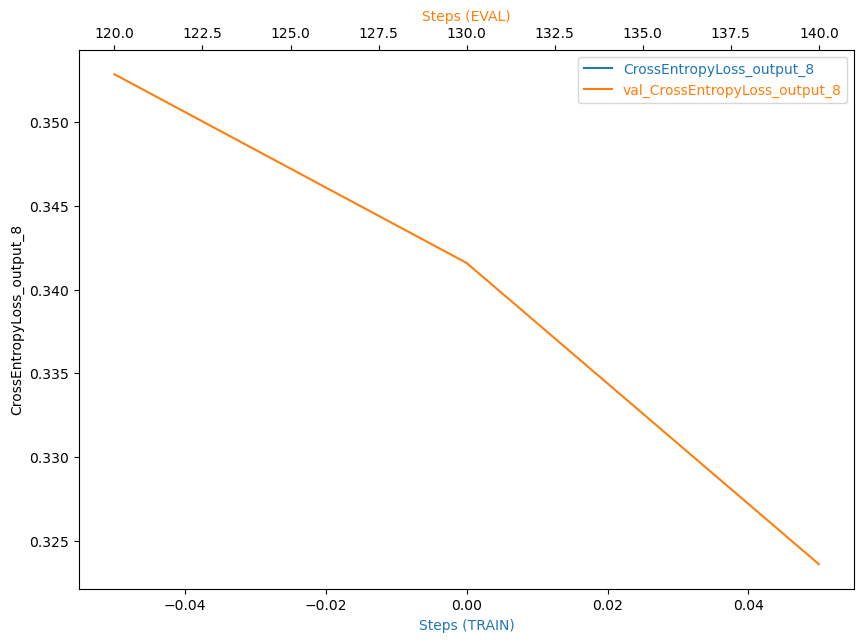

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


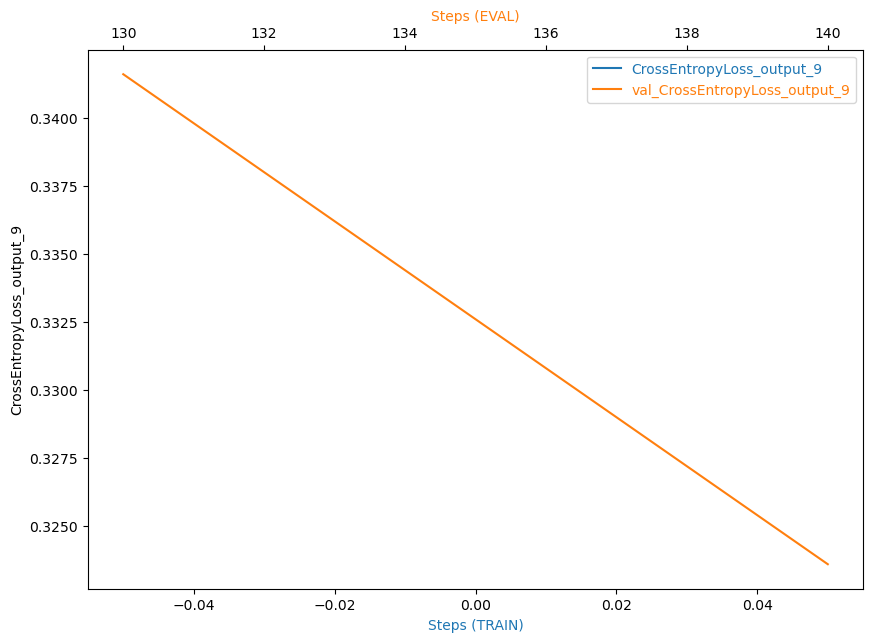

In [22]:
plt.figure(figsize=[4,36])
for idx in range(0,10):
    plot_tensor(trial, f"CrossEntropyLoss_output_{idx}")


**TODO**: 
* Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?
* If not, suppose there was an error. What would that error look like and how would you have fixed it?

The phenomenon where the loss temporarily worsens during deep learning training is known as `Deep Double Descent`. This behavior is attributed to the characteristics of deep learning. Based on my research, I believe the following two approaches are effective:
* Regularization: I will re-run the experiment by setting a regularization term in the criterion.
* Parameter size variation: I will use models with different parameter sizes.


In [23]:
# TODO: Display the profiler output

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-2024-07-28-01-22-27-589
Region: us-west-2


In [24]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-studio-146700155215-5c7uj0emdok/nd009t-c2/train_model/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-studio-146700155215-5c7uj0emdok/nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/profiler-output


Profiler data from system is available
You will find the profiler report in s3://sagemaker-studio-146700155215-5c

In [25]:
! aws s3 ls {rule_output_path} --recursive

2024-07-28 01:48:21     443726 nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-07-28 01:48:21     304079 nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-07-28 01:48:14        561 nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-07-28 01:48:14      82347 nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-07-28 01:48:14       2046 nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-07-28 01:48:14        310 nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-07-28 01:48:14        605 nd009t-c2/train_m

In [26]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-studio-146700155215-5c7uj0emdok/nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-studio-146700155215-5c7uj0emdok/nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-studio-146700155215-5c7uj0emdok/nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-studio-146700155215-5c7uj0emdok/nd009t-c2/train_model/pytorch-2024-07-28-01-22-27-589/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler

In [27]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

# Model Deploying

In [22]:
# TODO: Deploy your model to an endpoint
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )


pytorch_model = PyTorchModel(model_data=estimator.model_data,
                             role=role, 
                             entry_point='pred.py',
                             py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1,
                                 instance_type='ml.m5.large')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-studio-146700155215-5c7uj0emdok/nd009t-c2/train_model/pytorch-2024-07-28-10-34-09-670/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-146700155215/pytorch-inference-2024-07-28-10-59-13-624/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-07-28-10-59-17-414
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-07-28-10-59-18-087
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-07-28-10-59-18-087


-------!

In [29]:
# TODO: Run an prediction on the endpoint
with open("./prediction/Affenpinscher_00003.jpg", "rb") as f:
    payload = f.read()

inference = predictor.predict(payload)
np.argmax(inference) + 1

1

In [30]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-07-28-10-59-18-087
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-07-28-10-59-18-087
